Matplotlib is building the font cache; this may take a moment.
C:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


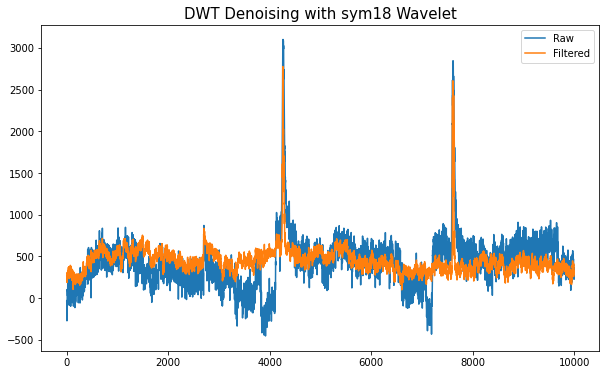

In [2]:
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt,log10
from sklearn.metrics import mean_squared_error

def madev(d, axis=None):
    """ Median absolute deviation of a signal """
#     return np.mean(np.absolute(d - np.mean(d, axis)), axis)
    return np.median(np.absolute(d))

def wavelet_denoising(x):
    c = pywt.wavedec(x,"sym18", mode="per",level = 4)
    
    sigma = (1/0.6745) * madev(c[-1])
    
    univ_thresh = sigma * np.sqrt(2 * np.log(len(x)))
    
    c[1:] = (pywt.threshold(i, value=univ_thresh, mode='hard') for i in c[1:])
    
    return pywt.waverec(c, "sym18", mode='per')


signal = pd.read_csv('data/train/subj1_data.csv')
signal = signal.drop("id", axis=1)

# from sklearn.preprocessing import StandardScaler,MinMaxScaler
# scaler= StandardScaler()

# signal = pd.DataFrame(scaler.fit_transform(signal))


# for wav in pywt.wavelist(kind='discrete'):
#     try:
filtered = pd.DataFrame(wavelet_denoising(signal))

###PLOT###
plt.figure(figsize=(10, 6))
plt.plot(signal.iloc[:10000,0], label='Raw')
plt.plot(filtered.iloc[:10000,0], label='Filtered')
plt.legend()
plt.title("DWT Denoising with sym18 Wavelet", size=15)
plt.show()
#     except:
#         pass    